In [1]:
# import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
from scipy.integrate import odeint
from matplotlib.backends.backend_pdf import PdfPages

import csv

np.set_printoptions(precision=4, linewidth=200, suppress=True, edgeitems=5)

In [2]:
def saturation_specific_humidity(temp, press):
    """
    We assume a single liquid-to-vapor phase transition with the parameter values 
    of the Clausius–Clapeyron (CC) relation given in O’Gorman and Schneider (2008) 
    to determine the saturation specific humidity qs(T).

    """

    es0 = 610.78  # saturation vapor pressure at t0 (Pa)
    t0 = 273.16
    Rv = 461.5
    Lv = 2.5E6
    ep = 0.622  # ratio of gas constants of dry air and water vapor
    temp = temp + 273.15  # convert to Kelvin
    es = es0 * np.exp(-(Lv / Rv) * ((1 / temp) - (1 / t0)))
    qs = ep * es / press

    return qs

In [5]:
# The default run in WE15, Fig 2 uses the time-stepping parameters:
# n=400 % # of evenly spaced latitudinal gridboxes (equator to pole)
# nt=1e3 % # of timesteps per year (approx lower limit of stability)
# dur=200 % # of years for the whole run
# For a quicker computation, use the parameters:
# n = 100
# nt = 1000
n = 24
nt = 1000
dur = 30
dt = 1 / float(nt)
# Spatial Grid
dx = 1.0 / n  # grid box width
x = np.arange(dx / 2, 1 + dx / 2, dx)  # native grid
xb = np.arange(dx, 1, dx)

A = 193  # OLR when T = 0 (W m^-2)
B = 2.1  # OLR temperature dependence (W m^-2 K^-1)
cw = 9.8  # ocean mixed layer heat capacity (W yr m^-2 K^-1)
D = 0.5  # diffusivity for heat transport (W m^-2 K^-1)

S0 = 420  # insolation at equator (W m^-2)
S1 = 338  # insolation seasonal dependence (W m^-2)
S2 = 240  # insolation spatial dependence (W m^-2)
a0 = 0.7  # ice-free co-albedo at equator
a2 = 0.1  # ice=free co-albedo spatial dependence
ai = 0.4  # co-albedo where there is sea ice
aw = a0 - a2 * x**2  # open water albedo
F = 0  # radiative forcing (W m^-2)

Lv = 2.5E6  # latent heat of vaporization (J kg^-1)
cp = 1004.6  # heat capacity of air at constant pressure (J kg^-1 K^-1)
RH = 0.8  # relative humidity
Ps = 1E5  # surface pressure (Pa)
Fb = 4  # heat flux from ocean below (W m^-2)
k = 2  # sea ice thermal conductivity (W m^-2 K^-1)
Lf = 9.5  # sea ice latent heat of fusion (W yr m^-3)
cg = 0.01 * cw  # ghost layer heat capacity(W yr m^-2 K^-1)
gms_scale = 2  # ratio of MSE aloft to near surface, equatorial MSE
sigma = 0.4  # characteristic width for gaussian weighting function
# Further definitions
kLf = k * Lf

# Diffusion Operator (WE15, Appendix A)
lam = D / dx**2 * (1 - xb**2)
L1 = np.append(0, -lam)
L2 = np.append(-lam, 0)
L3 = -L1 - L2
diffop = -np.diag(L3[:-1] if n == 3 or n == 6 or n == 24 else L3) - \
    np.diag(L2[:n-1], 1) - np.diag(L1[1:n], -1)

# Definitions for implicit scheme on Tg
tau = 1e-5  # ghost layer coupling timescale (yr)
cg_tau = cg / tau
dt_tau = dt / tau
dc = dt_tau * cg_tau
M = B + cg_tau
kappa = (1 + dt_tau) * np.identity(n) - dt * diffop / cg

# Seasonal forcing (WE15 eq.3) 
ty = np.arange(dt / 2, 1 + dt / 2, dt)
S = (np.tile(S0 - S2 * x**2, [nt, 1]) -
        np.tile(S1 * np.cos(2 * np.pi * ty), [n, 1]).T * np.tile(x, [nt, 1]))

In [6]:
# Set up output arrays, saving 100 timesteps/year
E100 = np.zeros([n, dur*100])
T100 = np.zeros([n, dur*100])
p = -1
m = -1

# Initial conditions
T = 7.5 + 20 * (1 - 2 * x**2)
Tg = T
E = cw * T

j = 0

# Integration (see WE15_NumericIntegration.pdf)
# Loop over Years
for years in range(0, dur):
    # Loop within One Year
    for i in range(0, int(nt)):
        m += 1
        # store 100 timesteps per year
        if (p + 1) * 10 == m:
            p += 1
            E100[:, p] = E
            T100[:, p] = T
        # forcing
        alpha = aw * (E > 0) + ai * (E < 0)  # WE15, eq.4
        C = alpha * S[i, :] + cg_tau * Tg - A
        # surface temperature
        T0 = C / (M - kLf / E)  # WE15, eq.A3
        T = E / cw * (E >= 0) + T0 * (E < 0) * (T0 < 0)  # WE15, eq.9
        # Forward Euler on E
        E = E + dt * (C - M * T + Fb + F)  # WE15, eq.A2
        # latent heat transport
        q = RH * saturation_specific_humidity(Tg, Ps)
        lht = dt * np.dot(diffop, Lv * q / cp)
        # Implicit Euler on Tg
        Tg = np.linalg.solve(kappa - np.diag(dc / (M - kLf / E) * (T0 < 0) * (E < 0)),
                                Tg + lht + (dt_tau * (E / cw * (E >= 0) + (ai * S[i, :] - A) / (M - kLf / E) * (T0 < 0) * (E < 0))))
    print('year %d complete' % (years + 1))

# output only converged, final year
tfin = np.linspace(0, 1, 100)
Efin = E100[:, -100:]
Tfin = T100[:, -100:]

year 1 complete
year 2 complete
year 3 complete
year 4 complete
year 5 complete
year 6 complete
year 7 complete
year 8 complete
year 9 complete
year 10 complete
year 11 complete
year 12 complete
year 13 complete
year 14 complete
year 15 complete
year 16 complete
year 17 complete
year 18 complete
year 19 complete
year 20 complete
year 21 complete
year 22 complete
year 23 complete
year 24 complete
year 25 complete
year 26 complete
year 27 complete
year 28 complete
year 29 complete
year 30 complete


In [7]:
# Compute hydrological cycle for final year
# Calculate diffusive heat transport, latent and total
x = np.reshape(x, (n, 1))
qfin = RH * saturation_specific_humidity(Tfin, Ps)
hfin = Tfin + Lv * qfin / cp  # in temperature units
Fa = -D * (1 - x**2) * np.gradient(hfin, axis=0) * n
Fla = -D * (1 - x**2) * np.gradient(Lv * qfin / cp, axis=0) * n

# Weighting function to partition transport into Hadley cell and eddy transports
w = np.exp(-x**2 / sigma**2)
F_hc = w * Fa
F_eddy = (1 - w) * Fa
Fl_eddy = (1 - w) * Fla

# Calculate latent heat transport by Hadley cell
hfin_eq = hfin[0, :]
gms = hfin_eq * gms_scale - hfin  # gross moist stability
psi = F_hc / gms  # mass flux
Fl_hc = -(Lv * qfin / cp) * psi

# Calculate E-P as the convergence of latent heat transport
Fl = Fl_hc + Fl_eddy
EminusP = np.gradient(Fl, axis=0) * n
x = np.reshape(x, (n,))  # for plotting

# WE15, Figure 2: Default Steady State Climatology
winter = 26  # time of coldest <T>
summer = 76  # time of warmest <T>
# compute seasonal ice edge
xi = np.zeros(100)
# if isempty(find(E<0,1))==0:
for j in range(0, len(tfin)):
    E = Efin[:, j]
    if any(E < 0):
        ice = np.where(E < 0)[0]
        xi[j] = x[ice[0]]
    else:
        xi[j] = max(x)

In [8]:
print(np.average(Tfin))

16.183250258762715


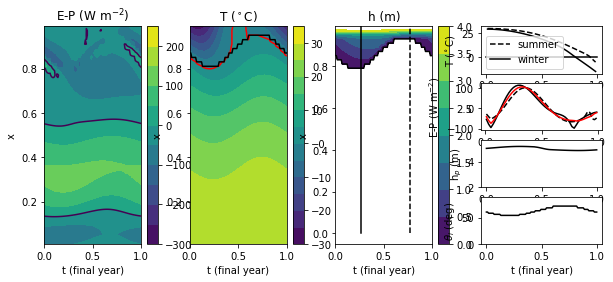

In [12]:
plt.figure(figsize=(10, 4))

#  # plot enthalpy (Fig 2a)
#  plt.subplot(141)
#  clevsE = np.append(np.arange(-40,20,20),np.arange(50,350,50))
#  plt.contourf(tfin,x,Efin,clevsE)
#  plt.colorbar()
#  # plot ice edge on E
#  plt.plot(tfin,xi,'k')
#  plt.xlabel('t (final year)')
#  plt.ylabel('x')
#  plt.title(r'E (J m$^{-2}$)')

# plot E-P
plt.subplot(141)
clevsE = np.arange(-300, 300, 50)
plt.contourf(tfin, x, EminusP, clevsE)
plt.colorbar()
plt.contour(tfin, x, EminusP, 'k', levels=[0])
plt.xlabel('t (final year)')
plt.ylabel('x')
plt.title(r'E-P (W m$^{-2}$)')

# plot temperature (Fig 2b)
plt.subplot(142)
clevsT = np.arange(-30.001, 35., 5.)
plt.contourf(tfin, x, Tfin, clevsT)
plt.colorbar()
# plot ice edge on T
plt.plot(tfin, xi, 'k')
# plot T=0 contour (the region between ice edge and T=0 contour is the
# region of summer ice surface melt)
plt.contour(tfin, x, Tfin, [-0.001], colors='r', linestyles='-')
plt.xlabel('t (final year)')
plt.ylabel('x')
plt.title(r'T ($^\circ$C)')

# plot the ice thickness (Fig 2c)
plt.subplot(1, 4, 3)
clevsh = np.arange(0.00001, 4.5, .5)
hfin = -Efin / Lf * (Efin < 0)
plt.contourf(tfin, x, hfin, clevsh)
plt.colorbar()
# plot ice edge on h
plt.contour(tfin, x, hfin, [0], colors='k')
plt.plot([tfin[winter], tfin[winter]], [0, max(x)], 'k')
plt.plot([tfin[summer], tfin[summer]], [0, max(x)], 'k--')
plt.xlabel('t (final year)')
plt.ylabel('x')
plt.title('h (m)')

# plot temperature profiles (Fig 2d)
plt.subplot(444)
Summer, = plt.plot(x, Tfin[:, summer], 'k--', label='summer')
Winter, = plt.plot(x, Tfin[:, winter], 'k', label='winter')
plt.plot([0, 1], [0, 0], 'k')
plt.xlabel('x')
plt.ylabel(r'T ($^\circ$C)')
plt.legend(handles=[Summer, Winter], loc=0)

#  # plot ice thickness profiles (Fig 2e)
#  plt.subplot(448)
#  plt.plot(x,hfin[:,summer],'k--')
#  plt.plot(x,hfin[:,winter],'k')
#  plt.plot([0,1], [0,0],'k')
#  plt.xlim([0.7,1])
#  plt.xlabel('x')
#  plt.ylabel('h (m)')

# plot E-P profiles
plt.subplot(448)
plt.plot(x, EminusP[:, summer], 'k--')
plt.plot(x, EminusP[:, winter], 'k')
plt.plot(x, np.mean(EminusP, axis=1), 'r')
plt.xlabel('x')
plt.ylabel(r'E-P (W m$^{-2}$)')

# plot seasonal thickness cycle at pole (Fig 2f)
plt.subplot(4, 4, 12)
plt.plot(tfin, hfin[-1, :], 'k')
plt.xlabel('t (final year)')
plt.ylabel(r'h$_p$ (m)')
plt.ylim([2, 1.1*max(hfin[-1, :])])

# plot ice edge seasonal cycle (Fig 2g)
plt.subplot(4, 4, 16)
xideg = np.degrees(np.arcsin(xi))
plt.plot(tfin, xideg, 'k-')
plt.ylim([0, 90])
plt.xlabel('t (final year)')
plt.ylabel(r'$\theta_i$ (deg)')

plt.show()

In [ ]:
dx = 1/5
x = np.arange(dx / 2, 1 + dx / 2, dx)  # native grid
cw = 9.8
T = 7.5 + 20 * (1 - 2 * x**2)
Tg = T
E = cw * T
print(E)
print(E<0)
print(1-(E<0))
print(E>=0)
print((E<0)*2)